In [1]:
import numpy as np
import pandas as pd
from fasterrisk.fasterrisk import RiskScoreClassifier, RiskScoreOptimizer
from sklearn.metrics import average_precision_score, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split

from scorepyo.models import EBMRiskScoreNew

from benchmark import read_adult_data, read_mushroom_data, read_heart_data, train_faster_risk, run_fasterrisk_benchmark

X,y,categorical_features = read_heart_data()
# X,y,categorical_features = read_mushroom_data()

X_train_orig, X_test, y_train_orig, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10
)

min_point_value = -2
max_point_value = 3
nb_max_features = 4

ebm_model = EBMRiskScoreNew(
    min_point_value=min_point_value,
    max_point_value=max_point_value,
    nb_max_features=nb_max_features,
    nb_additional_features=5,
    optimization_metric="roc_auc",
)

# if use_calib:
#     X_train, X_calib, y_train, y_calib = train_test_split(
#         X_train_orig, y_train_orig, test_size=0.2, random_state=random_state_calib
#     )
# else:
X_train = X_train_orig.copy()
y_train = y_train_orig.copy()
X_calib = X_train
y_calib = y_train

ebm_model.fit(
    X_train,
    y_train,
    X_calib=X_calib,
    y_calib=y_calib,
    categorical_features=categorical_features,
)

binarizer = ebm_model._binarizer

X_train_binarized = binarizer.transform(X_train)
X_calib_binarized = binarizer.transform(X_calib)
X_test_binarized = binarizer.transform(X_test)

X_train_orig_binarized = binarizer.transform(X_train_orig)
y_train_fasterrisk = np.where(y_train_orig == 0, -1, 1)

# faster_risk_model = train_faster_risk(
#     X_train_orig_binarized,
#     y_train_fasterrisk,
#     min_point_value,
#     max_point_value,
#     nb_max_features,
# )

# list_models = run_fasterrisk_benchmark(X_train_orig_binarized,
#     y_train_fasterrisk,
#     min_point_value,
#     max_point_value,
#     nb_max_features,
#     parent_size_range=[10],
#     child_size_range=(None,),
#     max_attempts_range=(50,),
#     num_ray_range=(10,),
#     lineSearch_early_stop_tolerance_range=(1e-3,),
#     )



# y_proba_faster_risk_train_orig = faster_risk_model.predict_prob(
#     X_train_orig_binarized.values
# )
# y_proba_faster_risk_train = faster_risk_model.predict_prob(X_train_binarized.values)
# y_proba_faster_risk_calib = faster_risk_model.predict_prob(X_calib_binarized.values)
# y_proba_faster_risk_test = faster_risk_model.predict_prob(X_test_binarized.values)

# y_proba_ebm_train_orig = ebm_model.predict_proba(X_train_orig)[:, 1].reshape(-1, 1)
# y_proba_ebm_train = ebm_model.predict_proba(X_train)[:, 1].reshape(-1, 1)
# y_proba_ebm_calib = ebm_model.predict_proba(X_calib)[:, 1].reshape(-1, 1)
# y_proba_ebm_test = ebm_model.predict_proba(X_test)[:, 1].reshape(-1, 1)

# proba_faster_risk = [
#     y_proba_faster_risk_train_orig,
#     y_proba_faster_risk_train,
#     y_proba_faster_risk_calib,
#     y_proba_faster_risk_test,
# ]
# proba_ebm = [
#     y_proba_ebm_train_orig,
#     y_proba_ebm_train,
#     y_proba_ebm_calib,
#     y_proba_ebm_test,
# ]

# targets = [y_train_orig, y_train, y_calib, y_test]

# metrics = [log_loss, average_precision_score, roc_auc_score]

# data_metrics = []
# for list_y_probas in [proba_faster_risk, proba_ebm]:
#     for y_proba, y_true in zip(list_y_probas, targets):
#         for metric in metrics:
#             data_metrics.append(metric(y_true.astype(int), y_proba))



In [9]:
nb_max_features = 4
for nb_additional_features in [1, 3, 5,6,7, 10]:
    print("nb_additional_features", nb_additional_features)
    ebm_model_vanilla = EBMRiskScoreNew(
        min_point_value=min_point_value,
        max_point_value=max_point_value,
        nb_max_features=nb_max_features,
        nb_additional_features=nb_additional_features,
        optimization_metric="roc_auc",
    )

    ebm_model_numpy = EBMRiskScoreNew(
        min_point_value=min_point_value,
        max_point_value=max_point_value,
        nb_max_features=nb_max_features,
        nb_additional_features=nb_additional_features,
        optimization_metric="roc_auc",
    )


    ebm_model_dask = EBMRiskScoreNew(
        min_point_value=min_point_value,
        max_point_value=max_point_value,
        nb_max_features=nb_max_features,
        nb_additional_features=nb_additional_features,
        optimization_metric="roc_auc",
    )

    
    print('\t model numpy')
    %timeit ebm_model_numpy.fit_numpy(X_train,y_train,X_calib=X_calib,y_calib=y_calib,categorical_features=categorical_features)

    print()
    print('\t model dask')
    %timeit ebm_model_dask.fit_dask(X_train,y_train,X_calib=X_calib,y_calib=y_calib,categorical_features=categorical_features)

    print('\t model vanilla')
    %timeit ebm_model_vanilla.fit(X_train,y_train,X_calib=X_calib,y_calib=y_calib,categorical_features=categorical_features)
    print()


nb_additional_features 1
	 model numpy
481 ms ± 164 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

	 model dask
434 ms ± 47.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
	 model vanilla
537 ms ± 40.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

nb_additional_features 3
	 model numpy
453 ms ± 54.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

	 model dask
432 ms ± 31.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
	 model vanilla
1.27 s ± 35.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

nb_additional_features 5
	 model numpy
593 ms ± 34.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

	 model dask
510 ms ± 39.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
	 model vanilla
3.74 s ± 43.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

nb_additional_features 6
	 model numpy
773 ms ± 67.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

	 model dask
597 ms ± 24.9 ms per loop (mean ± std. dev. of 7 runs, 1 l

In [12]:
ebm_model_numpy.summary()

| FEATURE-POINT CARD |
| Feature                                                   | Description                                               | Point(s)   |       |
|:----------------------------------------------------------|:----------------------------------------------------------|:-----------|:------|
| number of major vessels (0-3) colored by flourosopy < 0.5 | number of major vessels (0-3) colored by flourosopy < 0.5 | -2.0       | ...   |
| the slope of the peak exercise ST segment < 1.5           | the slope of the peak exercise ST segment < 1.5           | -1.0       | + ... |
| chest pain type_4.0                                       | chest pain type_4.0                                       | 2.0        | + ... |
| thal_7.0                                                  | thal_7.0                                                  | 2.0        | + ... |
|                                                           |                                                          

In [13]:
ebm_model_dask.summary()

| FEATURE-POINT CARD |
| Feature                                                   | Description                                               | Point(s)   |       |
|:----------------------------------------------------------|:----------------------------------------------------------|:-----------|:------|
| number of major vessels (0-3) colored by flourosopy < 0.5 | number of major vessels (0-3) colored by flourosopy < 0.5 | -2.0       | ...   |
| the slope of the peak exercise ST segment < 1.5           | the slope of the peak exercise ST segment < 1.5           | -1.0       | + ... |
| chest pain type_4.0                                       | chest pain type_4.0                                       | 2.0        | + ... |
| thal_7.0                                                  | thal_7.0                                                  | 2.0        | + ... |
|                                                           |                                                          

In [14]:
ebm_model_vanilla.summary()

| FEATURE-POINT CARD |
| Feature                                                   | Description                                               | Point(s)   |       |
|:----------------------------------------------------------|:----------------------------------------------------------|:-----------|:------|
| number of major vessels (0-3) colored by flourosopy < 0.5 | number of major vessels (0-3) colored by flourosopy < 0.5 | -2.0       | ...   |
| the slope of the peak exercise ST segment < 1.5           | the slope of the peak exercise ST segment < 1.5           | -1.0       | + ... |
| chest pain type_4.0                                       | chest pain type_4.0                                       | 2.0        | + ... |
| thal_7.0                                                  | thal_7.0                                                  | 2.0        | + ... |
|                                                           |                                                          

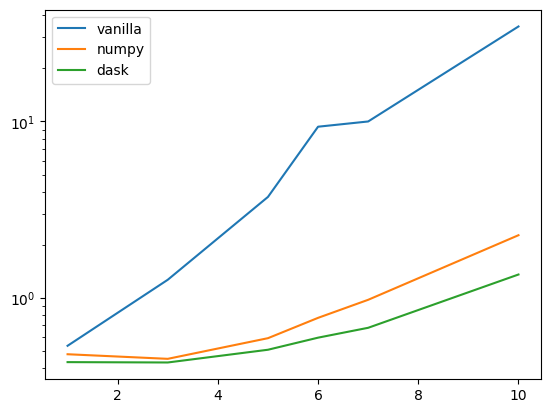

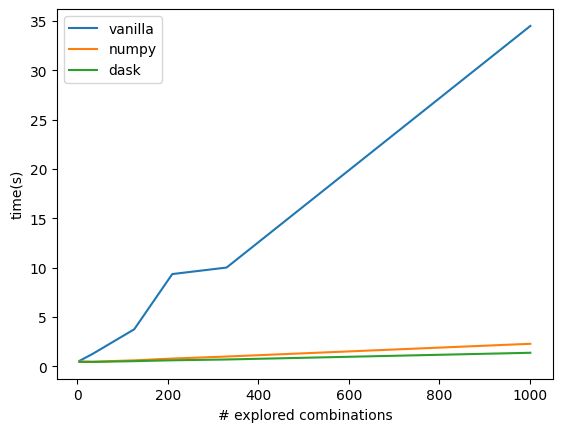

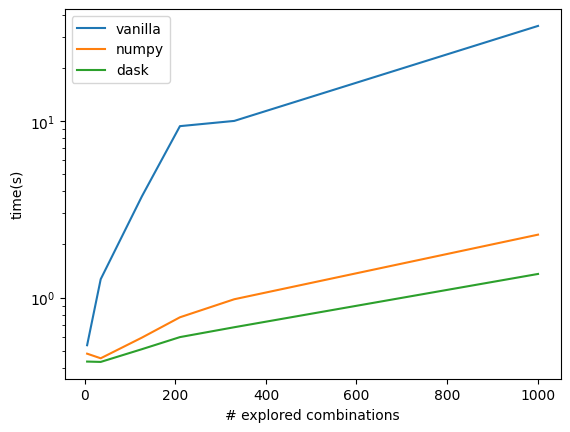

In [16]:
import itertools

list_nb_additional_features = [1, 3, 5,6,7, 10]
list_nb_combi =  [ len(
            list(itertools.combinations(list(range(4+i)), 4))
        ) for i in list_nb_additional_features]

time_numpy = [0.481, 0.453, 0.593, 0.773, 0.978, 2.27]
time_dask =  [0.434, 0.432, 0.510, 0.597,0.679,1.36]
time_vanilla = [ 0.537,1.27, 3.74, 9.34,10,34.5] 

import matplotlib.pyplot as plt

plt.plot(list_nb_additional_features, time_vanilla, label='vanilla')
plt.plot(list_nb_additional_features, time_numpy, label='numpy')
plt.plot(list_nb_additional_features, time_dask, label='dask')
plt.legend()
plt.yscale('log')
plt.show()

plt.plot(list_nb_combi, time_vanilla, label='vanilla')
plt.plot(list_nb_combi, time_numpy, label='numpy')
plt.plot(list_nb_combi, time_dask, label='dask')
plt.legend()
plt.ylabel('time(s)')
plt.xlabel('# explored combinations')
# plt.yscale('log')
plt.show()

plt.plot(list_nb_combi, time_vanilla, label='vanilla')
plt.plot(list_nb_combi, time_numpy, label='numpy')
plt.plot(list_nb_combi, time_dask, label='dask')
plt.legend()
plt.yscale('log')
plt.ylabel('time(s)')
plt.xlabel('# explored combinations')
plt.show()


In [3]:
ebm_model = EBMRiskScoreNew(
    min_point_value=min_point_value,
    max_point_value=max_point_value,
    nb_max_features=nb_max_features,
    nb_additional_features=3,
    optimization_metric="roc_auc",
)
%timeit ebm_model.fit_numpy(X_train,y_train,X_calib=X_calib,y_calib=y_calib,categorical_features=categorical_features)

564 ms ± 7.52 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
%timeit ebm_model.fit_dask(X_train,y_train,X_calib=X_calib,y_calib=y_calib,categorical_features=categorical_features)

498 ms ± 14.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [2]:


import numba

def fast_numba_auc(y_true: np.array, y_score, sample_weight: np.array=None) -> float:
    """a function to calculate AUC via python + numba.
    Args:
        y_true (np.array): 1D numpy array as true labels.
        y_score (np.array): 1D numpy array as probability predictions.
        sample_weight (np.array): 1D numpy array as sample weights, optional.
    Returns:
        AUC score as float
    """
    if sample_weight is None:
        return fast_numba_auc_nonw(y_true=y_true, y_score=y_score)
    else:
        return fast_numba_auc_w(y_true=y_true, y_score=y_score, sample_weight=sample_weight)


@numba.njit
def trapezoid_area(x1: float, x2: float, y1: float, y2: float) -> float:
    dx = x2 - x1
    dy = y2 - y1
    return dx * y1 + dy * dx / 2.0


@numba.njit
def fast_numba_auc_nonw(y_true: np.array, y_score) -> float:
    y_true = (y_true == 1)

    desc_score_indices = np.argsort(y_score, kind="mergesort")[::-1]
    y_score = y_score[desc_score_indices]
    y_true = y_true[desc_score_indices]

    prev_fps = 0
    prev_tps = 0
    last_counted_fps = 0
    last_counted_tps = 0
    auc = 0.0
    for i in range(len(y_true)):
        tps = prev_tps + y_true[i]
        fps = prev_fps + (1 - y_true[i])
        if i == len(y_true) - 1 or y_score[i+1] != y_score[i]:
            auc += trapezoid_area(last_counted_fps, fps, last_counted_tps, tps)
            last_counted_fps = fps
            last_counted_tps = tps
        prev_tps = tps
        prev_fps = fps
    return auc / (prev_tps*prev_fps)

@numba.njit
def fast_numba_auc_w(y_true: np.array, y_score, sample_weight: np.array) -> float:
    y_true = (y_true == 1)

    desc_score_indices = np.argsort(y_score, kind="mergesort")[::-1]
    y_score = y_score[desc_score_indices]
    y_true = y_true[desc_score_indices]
    sample_weight = sample_weight[desc_score_indices]

    prev_fps = 0
    prev_tps = 0
    last_counted_fps = 0
    last_counted_tps = 0
    auc = 0.0
    for i in range(len(y_true)):
        weight = sample_weight[i]
        tps = prev_tps + y_true[i] * weight
        fps = prev_fps + (1 - y_true[i]) * weight
        if i == len(y_true) - 1 or y_score[i+1] != y_score[i]:
            auc += trapezoid_area(last_counted_fps, fps, last_counted_tps, tps)
            last_counted_fps = fps
            last_counted_tps = tps
        prev_tps = tps
        prev_fps = fps
    return auc / (prev_tps * prev_fps)

In [3]:
import dask.array as da
import dask 
import itertools

In [4]:
from dask.distributed import Client
client = Client()
# client.dashboard_link
# 'http://127.0.0.1:8787/status'

In [5]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 7.73 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:62777,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 7.73 GiB
Comm: tcp://127.0.0.1:62799,Total threads: 2
Dashboard: http://127.0.0.1:62801/status,Memory: 1.93 GiB
Nanny: tcp://127.0.0.1:62780,


In [6]:

df_info = ebm_model._binarizer.df_score_feature.copy()

ebm_model.nb_additional_features = 20

# Rank the binary feature by likeliness to be important for the risk score model
# The current estimated importance is the log odd computed by the EBM model x number of positive samples for
# that binary feature.
# The cardinality of the positive samples is de emphasize by taking the 0.95 power.
# TODO: take into account the impact of having mixed class in the samples

df_info["abs_contribution"] = df_info[
    "EBM_log_odds_contribution"
].abs() * df_info["density"].fillna(0).astype(int).pow(
    0.95
)  # to de emphasize large values impact

# Compute the reduced pool of top features to choose from
pool_top_features = df_info.sort_values(
    by="abs_contribution", ascending=False
).index[: ebm_model.nb_max_features + ebm_model.nb_additional_features]

# Compute bounds for points for each feature to reduce optimization space
# -> negative points for negative log odds
# -> positive points for positive log odds
df_sense = df_info.sort_values(by="abs_contribution", ascending=False).iloc[
    : ebm_model.nb_max_features + ebm_model.nb_additional_features
]
df_sense["lower_bound_point"] = np.where(
    df_sense["EBM_log_odds_contribution"] > 0,
    min([1, ebm_model.max_point_value]),
    ebm_model.min_point_value,
)
df_sense["upper_bound_point"] = np.where(
    df_sense["EBM_log_odds_contribution"] > 0,
    ebm_model.max_point_value,
    max([-1, ebm_model.min_point_value]),
)

# Define all possible integer values for each binary feature
dict_point_ranges = {
    f: {
        "all_points": np.arange(
            df_sense.loc[f, "lower_bound_point"],
            df_sense.loc[f, "upper_bound_point"] + 1e-3,
            1,
        ),
    }
    for f in pool_top_features
}

best_metric = 1e9

_count = 0
# For all combinations of nb_max_feature from the set of selected binary features
nb_combi = len(
    list(itertools.combinations(pool_top_features, ebm_model.nb_max_features))
)

# Max number of point combination
dim_max_point_combination = max(len(dict_point_ranges[f]["all_points"]) for f in pool_top_features)**ebm_model.nb_max_features

# Compute cube of all points combination :
# number of k feature among n x cardinality of feature pool x max number of point combination for k features
cube = np.zeros(shape=(nb_combi, len(pool_top_features),dim_max_point_combination), dtype=np.float16)

# for each feature combination, compute point combinations
for i,top_features in enumerate(itertools.combinations(
    pool_top_features, ebm_model.nb_max_features)
):
    # Gather all point ranges for each binary feature
    all_points_by_feature = [
        dict_point_ranges[f]["all_points"]  if f in top_features  else [0] for f in pool_top_features 
    ]

    # Compute the cartesian product of all possible point values for each feature
    # This creates a nxd matrix with n being the number of combinations of points for each binary feature
    # and d being the number of selected binary features
    all_points_possibilities = np.array(
        list(itertools.product(*all_points_by_feature))
    )
    all_points_possibilities = all_points_possibilities.T
#     all_points_possibilities = all_points_possibilities.reshape(len(pool_top_features),-1)
    cube[i,:,:all_points_possibilities.shape[-1]] = all_points_possibilities


# TODO uncomment for the non dask version
# cube_augmented = np.einsum('ijk,jl->ijkl',
# cube,
#  X_train_binarized[list(pool_top_features)].values.T,
# optimize='optimal',
# dtype=np.int8,
# casting='unsafe',
 
#  )


dask_cube = da.from_array(cube, chunks=(50,len(pool_top_features),20))
dataset_transpose = X_train_binarized[list(pool_top_features)].values.T
dask_dataset_T = da.from_array(dataset_transpose, chunks=dataset_transpose.shape)



dask_cube_augmented = dask.array.einsum('ijk,jl->ijkl',
dask_cube,
dask_dataset_T,
optimize='optimal',
dtype=np.int8,
casting='unsafe',)

dask_score_all_case = dask_cube_augmented.sum(axis=1, dtype=np.int8).compute()

auc_results = np.zeros(shape=(dask_score_all_case.shape[0],dask_score_all_case.shape[1]))
for i in range(dask_score_all_case.shape[0]):
    for j in range(dask_score_all_case.shape[1]):
        auc_results[i,j] = fast_numba_auc(y_train.values,y_score=dask_score_all_case[i,j,:])

flatten_max_index = auc_results.argmax()
idx_max = np.unravel_index(flatten_max_index, auc_results.shape)
best_metric = auc_results[idx_max[0],idx_max[1]]
best_points = cube[idx_max[0],:,idx_max[1]]
best_feature_and_point_selection = [(point, f) for point,f in zip(best_points,list(pool_top_features)) if point !=0]
best_scenario, best_feature = zip(*best_feature_and_point_selection)
best_metric, best_scenario, best_feature


(0.9862787665748097,
 (3.0, -1.0, 2.0, -1.0),
 ('odor_eq_foul_1',
  'odor_eq_none_1',
  'gill_size_eq_narrow_1',
  'spore_print_color_eq_brown_1'))

In [ ]:
dask_cube

In [ ]:
dask_cube_augmented

In [ ]:
cube.shape

In [ ]:
from dask.distributed import Client
client = Client()
client.dashboard_link
# 'http://127.0.0.1:8787/status'

In [ ]:
i,j,k,l = cube_augmented.shape
i*j*k*l

In [ ]:
max_size = 6.7e9
size_dataset = 300
number_base_feature = 4
# number_additional_feature = 4
# dim_max_point_combination
x=21
max_combi_memory = max_size/ (dim_max_point_combination*size_dataset*(number_base_feature+x))
y = len(
    list(itertools.combinations(list(range(number_base_feature+x)), number_base_feature))
)
max_combi_memory, y


# TODO : Put this in the code and work aroung RAM problem when too many additional features 

In [ ]:
cube_augmented.shape

In [ ]:
# score for each feature combi, for each point possibilities, for each sample
score_all_case = cube_augmented.sum(axis=1)

In [ ]:


import numba

def fast_numba_auc(y_true: np.array, y_score: np.array, sample_weight: np.array=None) -> float:
    """a function to calculate AUC via python + numba.
    Args:
        y_true (np.array): 1D numpy array as true labels.
        y_score (np.array): 1D numpy array as probability predictions.
        sample_weight (np.array): 1D numpy array as sample weights, optional.
    Returns:
        AUC score as float
    """
    if sample_weight is None:
        return fast_numba_auc_nonw(y_true=y_true, y_score=y_score)
    else:
        return fast_numba_auc_w(y_true=y_true, y_score=y_score, sample_weight=sample_weight)


@numba.njit
def trapezoid_area(x1: float, x2: float, y1: float, y2: float) -> float:
    dx = x2 - x1
    dy = y2 - y1
    return dx * y1 + dy * dx / 2.0


@numba.njit
def fast_numba_auc_nonw(y_true: np.array, y_score: np.array) -> float:
    y_true = (y_true == 1)

    desc_score_indices = np.argsort(y_score, kind="mergesort")[::-1]
    y_score = y_score[desc_score_indices]
    y_true = y_true[desc_score_indices]

    prev_fps = 0
    prev_tps = 0
    last_counted_fps = 0
    last_counted_tps = 0
    auc = 0.0
    for i in range(len(y_true)):
        tps = prev_tps + y_true[i]
        fps = prev_fps + (1 - y_true[i])
        if i == len(y_true) - 1 or y_score[i+1] != y_score[i]:
            auc += trapezoid_area(last_counted_fps, fps, last_counted_tps, tps)
            last_counted_fps = fps
            last_counted_tps = tps
        prev_tps = tps
        prev_fps = fps
    return auc / (prev_tps*prev_fps)

@numba.njit
def fast_numba_auc_w(y_true: np.array, y_score: np.array, sample_weight: np.array) -> float:
    y_true = (y_true == 1)

    desc_score_indices = np.argsort(y_score, kind="mergesort")[::-1]
    y_score = y_score[desc_score_indices]
    y_true = y_true[desc_score_indices]
    sample_weight = sample_weight[desc_score_indices]

    prev_fps = 0
    prev_tps = 0
    last_counted_fps = 0
    last_counted_tps = 0
    auc = 0.0
    for i in range(len(y_true)):
        weight = sample_weight[i]
        tps = prev_tps + y_true[i] * weight
        fps = prev_fps + (1 - y_true[i]) * weight
        if i == len(y_true) - 1 or y_score[i+1] != y_score[i]:
            auc += trapezoid_area(last_counted_fps, fps, last_counted_tps, tps)
            last_counted_fps = fps
            last_counted_tps = tps
        prev_tps = tps
        prev_fps = fps
    return auc / (prev_tps * prev_fps)

In [ ]:
auc_results = np.zeros(shape=(score_all_case.shape[0],score_all_case.shape[1]))
for i in range(score_all_case.shape[0]):
    for j in range(score_all_case.shape[1]):
        auc_results[i,j] = fast_numba_auc(y_train.values,y_score=score_all_case[i,j,:])

In [ ]:
auc_results.shape

In [ ]:
flatten_max_index = auc_results.argmax()
idx_max = np.unravel_index(flatten_max_index, auc_results.shape)
best_metric = auc_results[idx_max[0],idx_max[1]]
best_points = cube[idx_max[0],:,idx_max[1]]
best_feature_and_point_selection = [(point, f) for point,f in zip(best_points,list(pool_top_features)) if point !=0]
best_scenario, best_feature = zip(*best_feature_and_point_selection)
best_metric, best_scenario, best_feature
# best_scenario = all_points_possibilities[
#                         idx_best_scenario, :
#                     ].copy()
#                     best_feature_selection = list(top_features).copy()

In [ ]:


# for top_features in itertools.combinations(
#     pool_top_features, ebm_model.nb_max_features
# ):
#     # Gather all point ranges for each binary feature
#     all_points_by_feature = [
#         dict_point_ranges[f]["all_points"] for f in top_features
#     ]

#     # Compute the cartesian product of all possible point values for each feature
#     # This creates a nxd matrix with n being the number of combinations of points for each binary feature
#     # and d being the number of selected binary features
#     all_points_possibilities = np.array(
#         list(itertools.product(*all_points_by_feature))
#     )

#     # TODO use np.argpartition in an evolution to take best logloss among best AP or other
#     # or conversely by giving a secondary metric and a size of contestant on secondary metric
#     if ebm_model.optimization_metric == "log_loss":
#         (
#             idx_best_scenario,
#             best_logloss_scenario,
#         ) = ebm_model._compute_logloss_all_scenario(
#             all_points_possibilities, X_binarized, y, top_features
#         )
#         if best_metric > best_logloss_scenario:
#             best_metric = best_logloss_scenario
#             best_scenario = all_points_possibilities[
#                 idx_best_scenario, :
#             ].copy()
#             best_feature_selection = list(top_features).copy()

#     else:
#         # Compute the score of samples in each scenario for all samples
#         score_samples_all_scenario = np.matmul(
#             X_binarized[list(top_features)].values, all_points_possibilities.T
#         )

#         average_precision_scores = ebm_model._compute_ranking_metric_scenario(
#             score_samples_all_scenario,
#             y,
#             roc_auc_score,  # average_precision_score
#         )

#         # TODO use np.argpartition in an evolution to take best logloss among best AP or other
#         # or conversely by giving a secondary metric and a size of contestant on secondary metric
#         # size_pool_scenario = 10
#         # ind_top_scenario = np.argpartition(
#         #     average_precision_scores, -size_pool_scenario
#         # )[-size_pool_scenario:]
#         average_precision_best_scenario = -np.max(average_precision_scores)

#         # size_pool_scenario = 1
#         # ind_top_scenario = np.argpartition(
#         #     average_precision_scores, -size_pool_scenario
#         # )[-size_pool_scenario:]

#         idx_best_scenario = np.argmax(average_precision_scores)
#         # print(average_precision_best_scenario)

#         # print()

#         # if tagged:
#         #     for ind in ind_top_scenario:
#         #         print(average_precision_scores[ind])
#         #         print(all_points_possibilities[ind, :])
#         #         print()
#         # (
#         #     idx_best_scenario,
#         #     best_logloss_scenario,
#         # ) = ebm_model._compute_logloss_all_scenario(
#         #     all_points_possibilities[ind_top_scenario, :],
#         #     X_binarized,
#         #     y,
#         #     top_features,
#         # )
#         # if tagged:
#         #     print(average_precision_scores[ind_top_scenario[idx_best_scenario]])
#         #     print(
#         #         all_points_possibilities[ind_top_scenario[idx_best_scenario], :]
#         #     )
#         #     print(best_logloss_scenario)
#         #     print()
#         #     print()

#         if best_metric > average_precision_best_scenario:
#             best_metric = average_precision_best_scenario
#             # idx_best_scenario = ind_top_scenario[idx_best_scenario]
#             # idx_best_scenario = ind_top_scenario[0]
#             best_scenario = all_points_possibilities[
#                 idx_best_scenario, :
#             ].copy()
#             best_feature_selection = list(top_features).copy()

#         ##### Previous version ####
#         # idx_best_scenario = np.argmax(average_precision_scores)
#         # best_points_scenario = all_points_possibilities[idx_best_scenario, :]

#         # if best_metric > average_precision_best_scenario:
#         #     best_metric = average_precision_best_scenario
#         #     best_scenario = best_points_scenario.copy()
#         #     best_feature_selection = list(top_features).copy()

In [ ]:
# faster_risk_model.reset_featureNames(list(X_train_binarized.columns[:]))
# faster_risk_model.print_model_card()

In [ ]:
metrics = [log_loss, average_precision_score, roc_auc_score]

data_metrics = []
for mod in list_models:
    res_ = []
    for metric in metrics:
        mod_ = mod[0]
        y_proba_ = mod_.predict_prob(X_test_binarized)
        res_.append(metric(y_test.astype(int), y_proba_))
    data_metrics.append(res_)


    
    

In [ ]:
df_analysis = pd.DataFrame(data=list_models, columns=['model', 'time', 'parent_size','child_size','max_attempts', 'num_ray', 'lineSearch_early_stop_tolerance'])
df_analysis[['log_loss', 'average_precision_score', 'roc_auc_score']] = data_metrics

In [ ]:
df_analysis

In [ ]:
ebm_model_adj = EBMRiskScoreNew(
    min_point_value=min_point_value,
    max_point_value=max_point_value,
    nb_max_features=nb_max_features,
    nb_additional_features=20,
    optimization_metric="roc_auc",
)

ebm_model_adj.fit(
    X_train,
    y_train,
    X_calib=X_calib,
    y_calib=y_calib,
    categorical_features=categorical_features,
)
(log_loss(y_test, ebm_model_adj.predict_proba(X_test)[:, 1].reshape(-1, 1)),
 average_precision_score(y_test, ebm_model_adj.predict_proba(X_test)[:, 1].reshape(-1, 1)), 
 roc_auc_score(y_test, ebm_model_adj.predict_proba(X_test)[:, 1].reshape(-1, 1)))

In [ ]:
import seaborn as sb 
import matplotlib.pyplot as plt
sb.scatterplot(data=df_analysis, x='time', y='log_loss')
plt.plot(100, log_loss(y_test, ebm_model.predict_proba(X_test)[:, 1].reshape(-1, 1)),"+")
# df_analysis

In [ ]:
df_analysis['log_loss'].unique()

In [ ]:
data_metrics

In [ ]:
ebm_model._binarizer.df_score_feature.sort_values(by='abs_contribution', ascending=False).head(25)

In [ ]:
ebm_model.summary()

In [ ]:
pd.options.display.max_columns=100
column_names = [
        model + "_" + datasets + "_" + metric
        for model in ["faster_risk", "ebm"]
        for datasets in ["train_orig", "train", "calib", "test"]
        for metric in ["log_loss", "average_precision", "roc_auc"]
    ]
# data_metrics
df_results = pd.DataFrame(data=[data_metrics], columns=column_names)
df_results[[c for c in df_results.columns if 'test' in c]]